# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
import sys
sys.path.append('E:/udacity_deep_reinforcement_learning/deep-reinforcement-learning-master/python')

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt
import torch


env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe") 

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

## Define methods to be used for training

In next two cells, I have defined three methods that will be used during the training
* reduce_learning_rate: This method reduces learning rate of optimizer by a factor
* learning_rate_adjustment_needed: This method checks whether learning rate adjustment is needed
* dqn: This method does the actual training using Double Deep Q learning algorithm. I have modified the original method as below:
- It takes, hidden layer and path for best and final model as parameters. 
- Logic is chnaged if after 400 episodes the mean score does not chnage by 1.0  over last 100 episdes, learning rate is reduced by a factor
- . Each episode if mean score is better the correspondin model is stored as best model so far. 
- In adddition to scores, I have added mean_score_list, number_of_steps_list which will store mean score after each episode  and steps taken in the episode which will be used for analysis later

### NOTE: Though as per project description, the goal of agent is to must get an average score of +13 over 100 consecutive episodes. But I have increased this limit to score as 17 over 100 consecutive episodes


In [6]:
def reduce_learning_rate(optimizer, episode, factor):
    """Reduce the learning rate by multiplying factor applicable only if epoch is more than 400
       Parameters:
       optimizer: Optimizer Used
       episode: Current Episode
       factor: The multiplication factory by which learning rate needs to be reduced
    """
    # If episode is less than 400, do not do anything
    if episode <=400:
        return
    
    # Update the learning Rate by multiplying by factor and update only if
    # new learning rate is not less than 1e-6
    for param_group in optimizer.param_groups:
        change_lr_value=np.around(param_group['lr']*factor, 8)
        if change_lr_value <= 0.000001:
            change_lr_value = 0.000001  
        param_group['lr'] = change_lr_value
        print("\nAs mean score over 100 episodes did not improve by 1.0 after 100 episodes, learning rate has been changed to: " +str(param_group['lr']))
            
def learning_rate_adjustment_needed(mean_score_list, episode, episode_last_lr_update):
    """This method finds out if adjustment of learning rate is needed or not. 
       The logic is find the difference between current mean score and the mean score 
       100 episodes back. If the diffrence is less than 1.0, then learning rate adjustment is needed
       and the method will return True, else the method will return False
      
       Parameters:
       mean_score_list: List
       episode: Current Episode
       factor: The multiplication factory by which learning rate needs to be reduced
    """
    if episode-episode_last_lr_update < 100:
        return False
    if len(mean_score_list) < 100:
        return False
    mean_score_current = mean_score_list[-1]
    mean_score_100_before = mean_score_list[-100]
    if (mean_score_current - mean_score_100_before) < 1.0:
        return True
    else:
        return False

In [7]:
from dqn_agent import Agent


def dqn(hidden_layers, best_model_save_path, final_model_save_path, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, learning_reduction_factor=0.7):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        hidden_layers(list): Dimension of hidden layers to be used
        best_model_save_path(string): Save path for best model
        final_model_save_path(string); Save path for final model
    Returns
    ======
       scores(list): List of raw scores of each episode
       mean_score_list(list): List of mean scores over last 100 episodes calcuated after each episode
       number_of_steps_list(list): List of number of steps taken in each episode
    """
    agent = Agent(state_size=37, action_size=4, seed=32, hidden_layers=hidden_layers)
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    mean_score_list = []                    # Store last 100 episode mean score
    number_of_steps_list = []          # Store number of steps taken
    eps = eps_start                    # initialize epsilon
    episode_last_lr_update = 0

    for i_episode in range(1, n_episodes+1):     
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0   # initialize the score
        for t in range(max_t): #this could also be while True instead
            action = agent.act(state, eps)        # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) #do the learning

            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        number_of_steps_list.append(t)    # Save number of steps taken in each episode
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        mean_score_list.append(np.mean(scores_window))   # Save the mean score over last 100 episodes
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=17.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), final_model_save_path)
            break
            
        if learning_rate_adjustment_needed(mean_score_list, i_episode, episode_last_lr_update):
            reduce_learning_rate(agent.get_optimizer(), i_episode, learning_reduction_factor)
            episode_last_lr_update = i_episode
            
        # Save the model if he mean score is greater than best so far
        if i_episode == 1:
            torch.save(agent.qnetwork_local.state_dict(), best_model_save_path) 
        else:
            if np.mean(scores_window) > np.max(mean_score_list):
                torch.save(agent.qnetwork_local.state_dict(), best_model_save_path) 
                
    # Store the final model        
    torch.save(agent.qnetwork_local.state_dict(), final_model_save_path) 
    return scores, mean_score_list, number_of_steps_list

## Try Neural Network of hidden layer dimensions as  32x64x32

Now I will try neural network of 32x64x32 to apply to DQN algoritm and se how it performs

In [8]:
best_model_save_path="dqn_best_model_32_64_32.pth"
final_model_save_path="dqn_final_model_32_64_32.pth"
hidden_layers=[32,64,32]

start_time = time.time()
scores, mean_score_list, number_of_steps_list = dqn(hidden_layers, best_model_save_path, final_model_save_path, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, learning_reduction_factor=0.7)
end_time = time.time()
print('Training Time is {}'.format(end_time-start_time ))


Episode 100	Average Score: 0.82
Episode 200	Average Score: 3.92
Episode 300	Average Score: 7.32
Episode 400	Average Score: 10.64
Episode 500	Average Score: 14.41
Episode 564	Average Score: 14.70
As mean score over 100 episodes did not improve by 1.0 after 100 episodes, learning rate has been changed to: 0.00035
Episode 600	Average Score: 14.81
Episode 664	Average Score: 15.42
As mean score over 100 episodes did not improve by 1.0 after 100 episodes, learning rate has been changed to: 0.000245
Episode 700	Average Score: 15.70
Episode 764	Average Score: 15.96
As mean score over 100 episodes did not improve by 1.0 after 100 episodes, learning rate has been changed to: 0.0001715
Episode 800	Average Score: 16.49
Episode 864	Average Score: 16.87
As mean score over 100 episodes did not improve by 1.0 after 100 episodes, learning rate has been changed to: 0.00012005
Episode 900	Average Score: 16.70
Episode 960	Average Score: 17.03
Environment solved in 860 episodes!	Average Score: 17.03
Traini

In [ ]:
best_mean_score=np.max(mean_score_list)
print("Best Mean Score: "+ str(best_mean_score))

## Plot scores against episodes

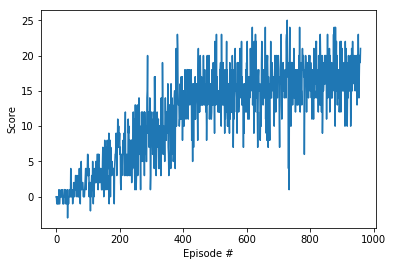

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Plot mean scores against episodes

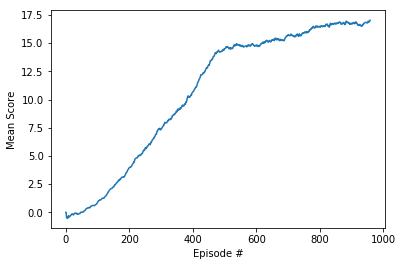

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_score_list)), mean_score_list)
plt.ylabel('Mean Score')
plt.xlabel('Episode #')
plt.show()

## Plot steps over episodes

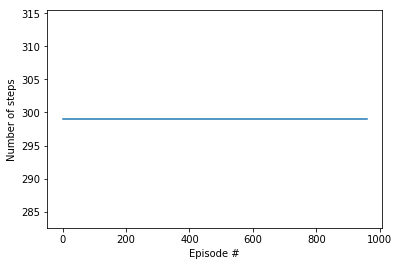

In [12]:
# plot the number of steps against episodes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(number_of_steps_list)), number_of_steps_list)
plt.ylabel('Number of steps')
plt.xlabel('Episode #')
plt.show()

## Try with Neural network having hidden layers 64x64x64

In [13]:
best_model_save_path="dqn_best_model_64_64_64.pth"
final_model_save_path="dqn_final_model_64_64_64.pth"
hidden_layers=[64,64,64]

start_time = time.time()
scores, mean_score_list, number_of_steps_list = dqn(hidden_layers, best_model_save_path, final_model_save_path, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, learning_reduction_factor=0.7)
end_time = time.time()
print('Training Time is {}'.format(end_time-start_time ))

Episode 100	Average Score: 0.47
Episode 200	Average Score: 3.16
Episode 300	Average Score: 6.96
Episode 400	Average Score: 10.30
Episode 500	Average Score: 11.76
Episode 600	Average Score: 13.76
Episode 698	Average Score: 14.79
As mean score over 100 episodes did not improve by 1.0 after 100 episodes, learning rate has been changed to: 0.00035
Episode 700	Average Score: 14.96
Episode 800	Average Score: 16.49
Episode 809	Average Score: 17.00
Environment solved in 709 episodes!	Average Score: 17.00
Training Time is 2193.7672097682953


## Plot scores against episodes

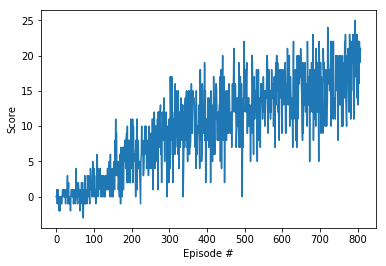

In [14]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Plot Mean scores over episodes

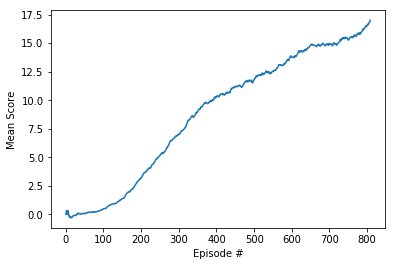

In [15]:
# plot the mean scores over last 100 consecutive episodes vs episode
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_score_list)), mean_score_list)
plt.ylabel('Mean Score')
plt.xlabel('Episode #')
plt.show()

## Plot number of steps against episodes

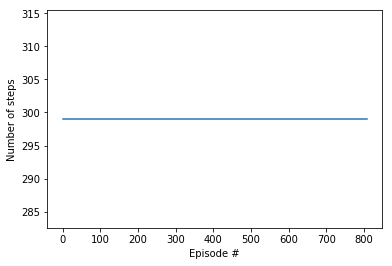

In [16]:
# plot the number of steps against episodes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(number_of_steps_list)), number_of_steps_list)
plt.ylabel('Number of steps')
plt.xlabel('Episode #')
plt.show()

## Conclusion

I have tried two different neural networks with DQN. One network having hidden dimensions 32x64x32 and second having hidden layer dimension 64x64x64.

Comparisons are as below:

i. Neural network having 64x64x64 solves in 809 episodes which is 151 episodes less than 32x64x32 which solves in 960 episodes
ii. Scores (Rewards) earned in each episode by 64x64x64 is having less variance than rewards earned by 32x64x32
ii. Slope of mean scores vs episodes in 64x64x64 network is much higher than slope of mean scores vs episodes curve used by 32x64x32

So, overall I found that 64x64x64 is performing better than 32x64x32 network



In [17]:

env.close()